In [13]:
import pandas as pd
from PIL import Image
import random
import albumentations as A
import numpy as np
from ultralytics import YOLO
import torch
import json

In [47]:
# Define augmentation functions
def rotate_image(image, angle):
    transform = A.Rotate(limit=(angle, angle), p=1.0)
    return transform(image=image)['image']

def gaussian_blur_image(image, sigma):
    transform = A.GaussianBlur(blur_limit=(sigma, sigma), p=1.0)
    return transform(image=image)['image']

def adv_blur_image(image, shift, intensity):
    transform = A.GaussNoise(var_limit=shift, noise_scale_factor=intensity, p=1.0)
    return transform(image=image)['image']

def drop_pixels(image, drop_fraction=0.01):
    height, width, _ = image.shape
    num_pixels_to_drop = int(width * height * drop_fraction)
    
    for _ in range(num_pixels_to_drop):
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        image[y, x] = [0, 0, 0]  # Drop to black or any other color
    
    return image

In [15]:
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    device = 'cuda'
else:
    device = 'cpu'

dataset_dir = 'E:/datasets'
dataset_name = 'DOTA_dataset_512'
coco_dir = f'{dataset_dir}/{dataset_name}'
eval_coco = f'{coco_dir}/val_coco.json'
output_dir = coco_dir
model_dir = 'E:/models'
model_name = 'DOTA_dataset_512_yolov8m_bb_aug'
model_path = f'{model_dir}/{model_name}/weights/best.pt'
model = YOLO(model_path)
batch_size = 64
num_workers = 8

with open(eval_coco, 'r') as f:
    coco_json = json.load(f)

img_id_to_img_dict = {img_dict['id']:img_dict['path'] for img_dict in coco_json['images']}

CUDA Available: True


6157

0: 512x512 (no detections), 162.5ms
Speed: 2.0ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


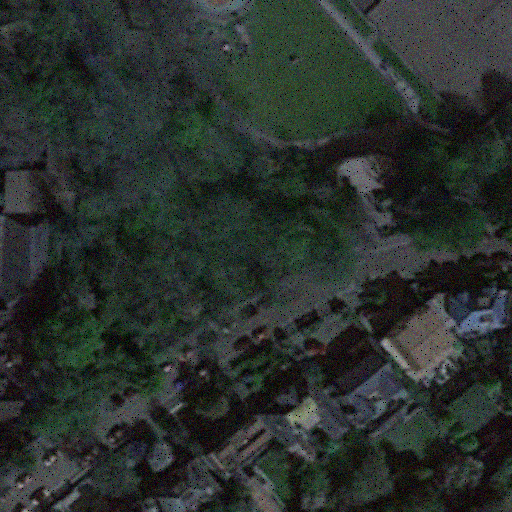

1173

0: 512x512 2 harbors, 133.6ms
Speed: 4.0ms preprocess, 133.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


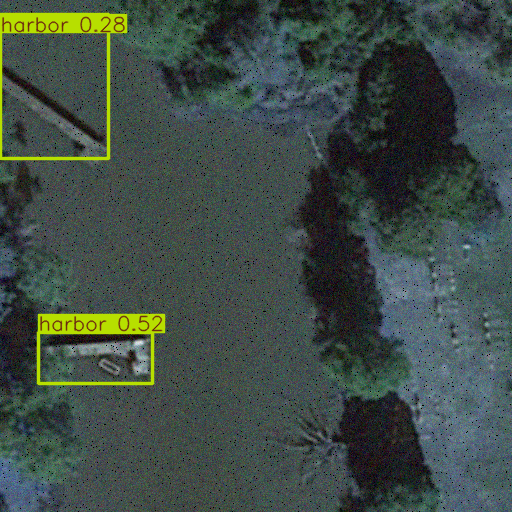

5838

0: 512x512 (no detections), 70.1ms
Speed: 1.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


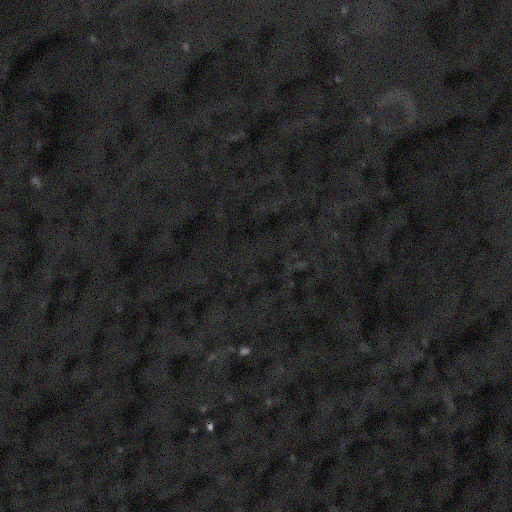

4040

0: 512x512 (no detections), 60.0ms
Speed: 2.5ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


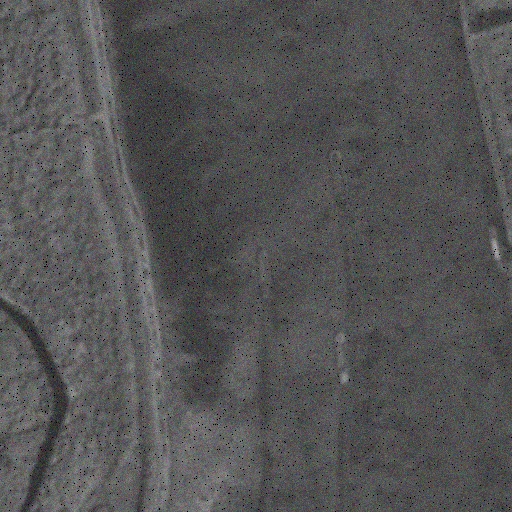

4419

0: 512x512 (no detections), 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


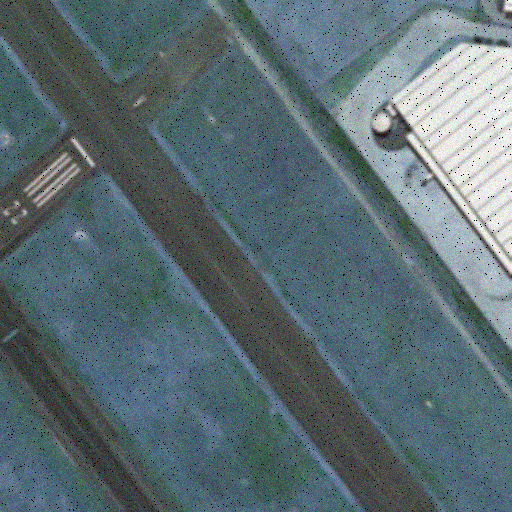

2789

0: 512x512 1 ship, 8 harbors, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


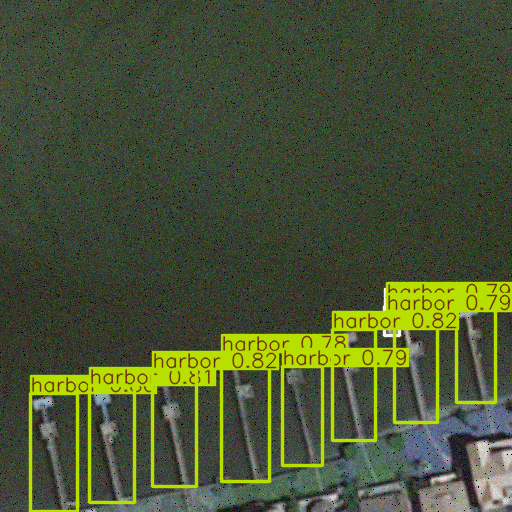

7821

0: 512x512 (no detections), 22.5ms
Speed: 1.0ms preprocess, 22.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


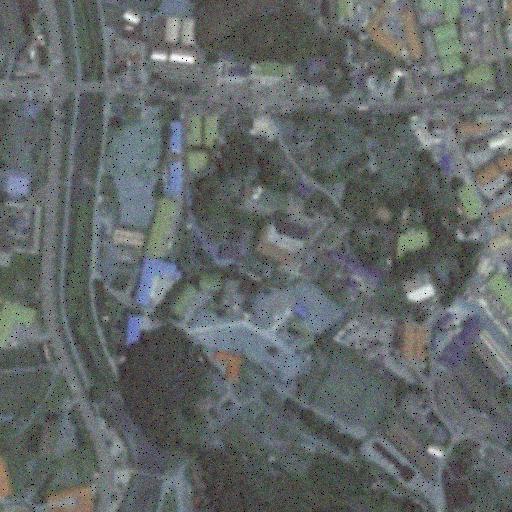

4842

0: 512x512 1 plane, 23.0ms
Speed: 1.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


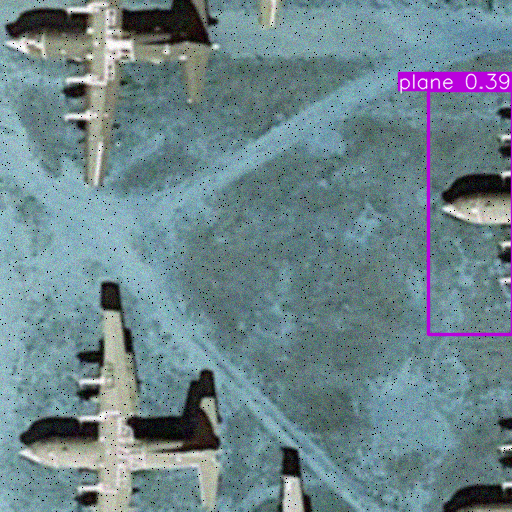

5130

0: 512x512 (no detections), 23.5ms
Speed: 2.0ms preprocess, 23.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


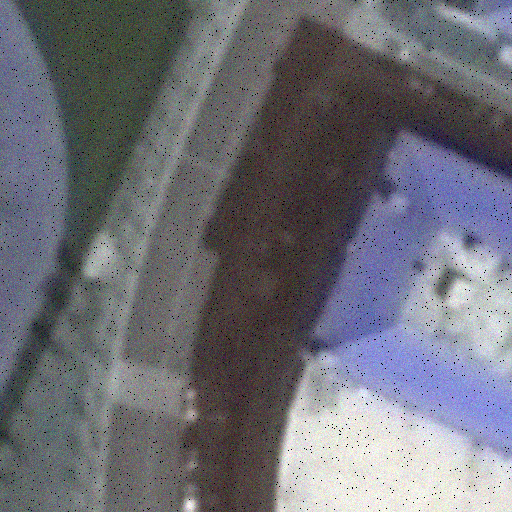

6143

0: 512x512 1 harbor, 22.5ms
Speed: 1.0ms preprocess, 22.5ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)


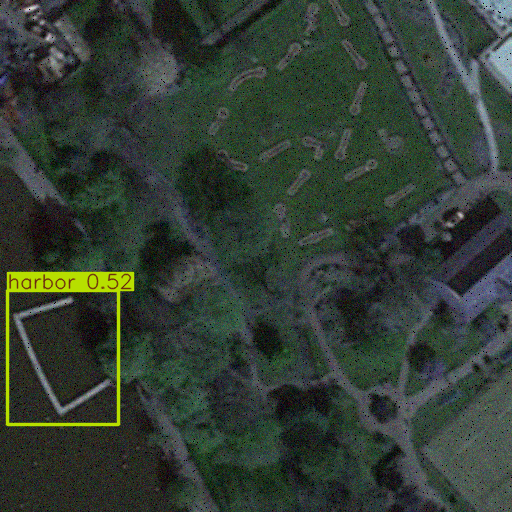

In [95]:
for i in range(10):
    id = random.choice(list(img_id_to_img_dict.keys()))
    print(id)
    #id = 7301
    #id = 7491
    #id = 6832
    image_path = img_id_to_img_dict[id]

    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)

    aug_img = gaussian_blur_image(img_np, 7)
    noise_var = 200
    aug_img = adv_blur_image(aug_img, (noise_var,noise_var), (1))
    aug_img = drop_pixels(aug_img, 0.01)
    aug_img = Image.fromarray(aug_img)
    yolo_results = model([aug_img])
    display(Image.fromarray(yolo_results[0].plot()))